In [ ]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### 30 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.20, 0.23) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

### Create, Train, and Perform Inference

In [ ]:
for kernel in covar_combinations:
    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True)
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        time_agg='30T',
        training_iter=100,
        lr=0.1,
        machine='gesamtmessung',
        update_score=True
    )

In [ ]:
mse, mape

In [ ]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module1,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    training_iter=100,
    lr=0.1,
    machine='Gesamtmessung',
    update_score=False
)

In [ ]:
mse, mape

### 10 minutes agg.

In [23]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        training_iter=75,
        lr=0.1,
        time_agg='10T',
        machine='gesamtmessung',
        update_score=True
    )

Iter 1 , Loss = 0.9114873849134992 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8768755803317103 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8426422145503807 , Noise = 0.5982204079627991
Iter 4 , Loss = 0.8087580811328267 , Noise = 0.5543948411941528
Iter 5 , Loss = 0.7751941687537164 , Noise = 0.5129894018173218
Iter 6 , Loss = 0.7420200651571657 , Noise = 0.47396594285964966
Iter 7 , Loss = 0.709403958613569 , Noise = 0.4372789263725281
Iter 8 , Loss = 0.6774392138743361 , Noise = 0.4028758108615875
Iter 9 , Loss = 0.6461698802432772 , Noise = 0.37069737911224365
Iter 10 , Loss = 0.6156912268631091 , Noise = 0.34067800641059875
Iter 11 , Loss = 0.5860547575735842 , Noise = 0.3127463161945343
Iter 12 , Loss = 0.5572317783656381 , Noise = 0.28682565689086914
Iter 13 , Loss = 0.5292560971157624 , Noise = 0.26283472776412964
Iter 14 , Loss = 0.5021628610049718 , Noise = 0.24068833887577057
Iter 15 , Loss = 0.47590665644101204 , Noise = 0.22029799222946167
Iter 16 , Loss = 0.45051314

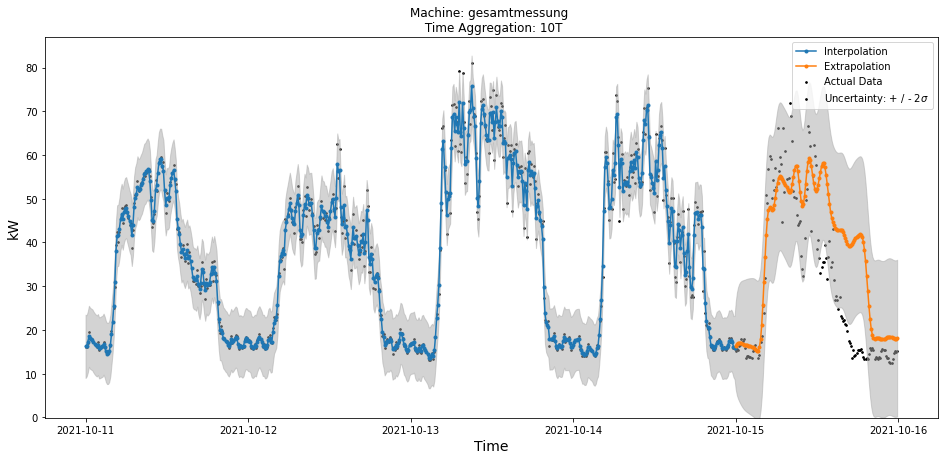

                 time     actual        machine
0 2021-10-13 07:10:00  79.277813  gesamtmessung


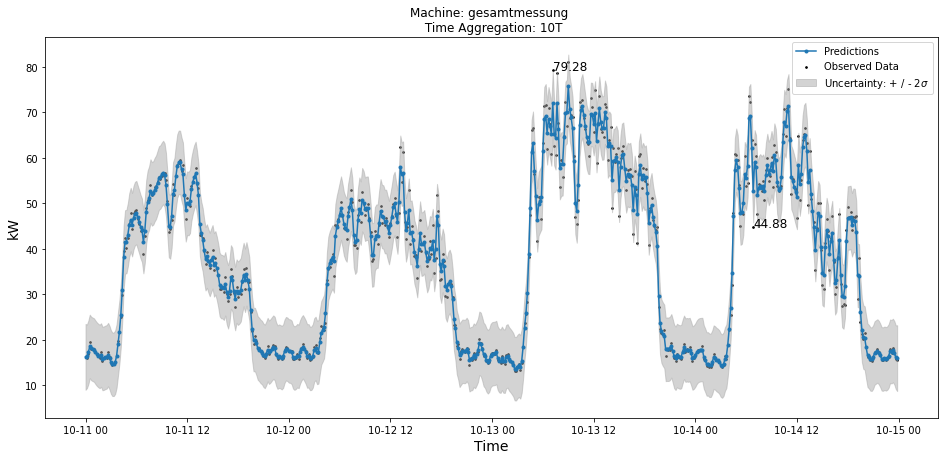

    index                time        machine control_limit  actual_kw  \
0       0 2021-10-15 08:00:00  gesamtmessung         upper  71.971929   
1       0 2021-10-15 12:20:00  gesamtmessung         lower  36.505573   
2       1 2021-10-15 12:30:00  gesamtmessung         lower  32.959260   
3       2 2021-10-15 12:40:00  gesamtmessung         lower  34.288270   
4       3 2021-10-15 12:50:00  gesamtmessung         lower  35.477738   
5       4 2021-10-15 13:00:00  gesamtmessung         lower  35.457914   
6       5 2021-10-15 13:10:00  gesamtmessung         lower  39.514313   
7       6 2021-10-15 13:20:00  gesamtmessung         lower  36.446612   
8       7 2021-10-15 13:30:00  gesamtmessung         lower  31.679767   
9       8 2021-10-15 15:10:00  gesamtmessung         lower  24.739720   
10      9 2021-10-15 15:30:00  gesamtmessung         lower  23.066486   
11     10 2021-10-15 15:40:00  gesamtmessung         lower  22.622124   
12     11 2021-10-15 15:50:00  gesamtmessung       

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:510: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:511: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


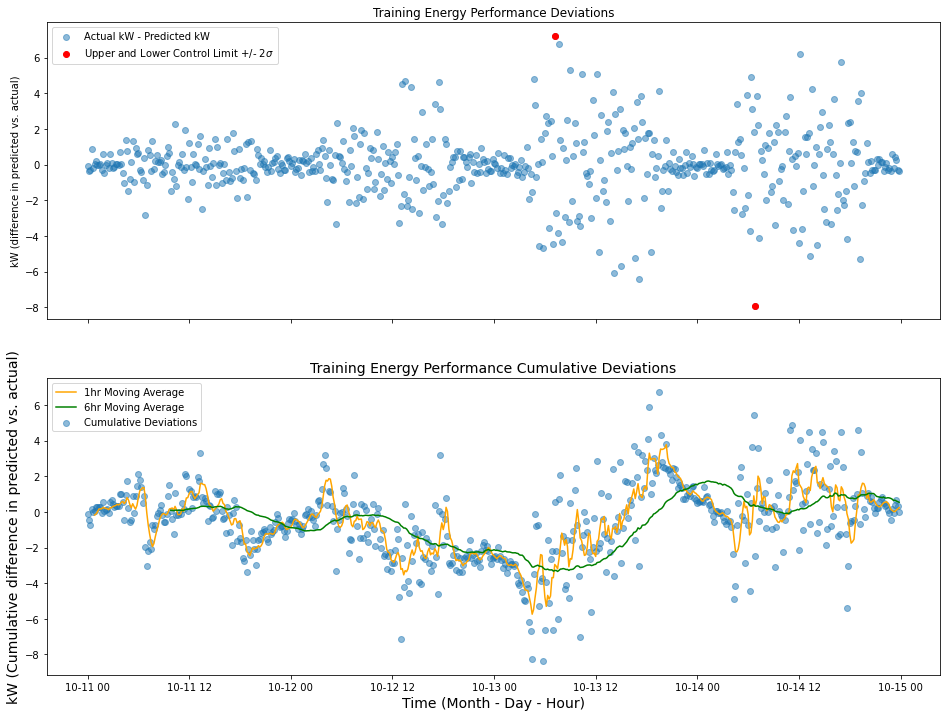

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:537: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:538: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


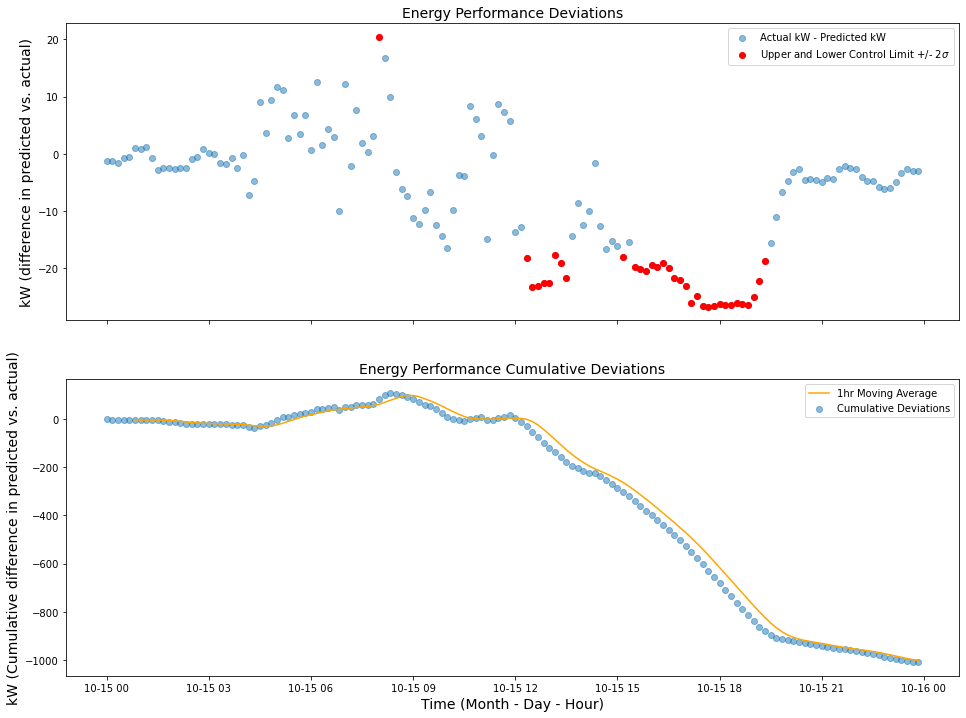

0.7638888888888888 4.90826592193981


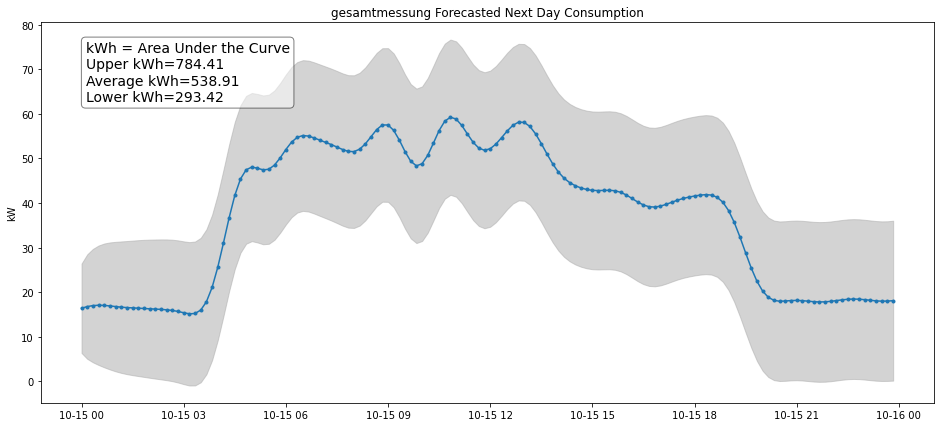

In [24]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module1,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=75,
    lr=0.1,
    time_agg='10T',
    machine='gesamtmessung',
    update_score=False)

In [25]:
mse, mape

(165.63949853737913, 0.44310322821459036)

### 5 minutes

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=75,
    lr=0.05,
    time_agg='5T',
    machine='Gesamtmessung',
    update_score=False
)